# Logging of the project

In this notebook you will find all the steps it took us to acurately predict the temperature of nuclear waste canister. 

### **Imports** 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

### **Loading of the datasets** 

In [3]:
coordinates_test = pd.read_csv("data/Coordinates_Test.csv")
coordinates_train = pd.read_csv("data/Coordinates_Training.csv")
humidity_test = pd.read_csv("data/Test_Time_humidity.csv")
humidity_train = pd.read_csv("data/Training_data_humidity.csv")
pressure_test = pd.read_csv("data/Test_Time_pressure.csv")
pressure_train = pd.read_csv("data/Training_data_pressure.csv")
temperature_train = pd.read_csv("data/Training_data_temperature.csv")

### **Imputing the datasets**


Actually, the sensor N_442 has not temperature values so as the data must coordinate well with the indices, we will remove it as well as other sensors with no data from all the datasets.

In [4]:
## The imputer actually deletes columns with no data so we need to identify the columns with no data first
## We need to know those sensors to remove the associated data in the other dataframes. 
## It is needed because the values are only linked by having the same index in all dataframes.

train_faulty_sensors = []
for sensor in pressure_train.columns[1:]:
    if temperature_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif pressure_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif humidity_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
print(f'Faulty sensors in train datasets: {train_faulty_sensors}')

test_faulty_sensors = []
for sensor in pressure_test.columns[1:]:
    if pressure_test[sensor].isna().all():
        test_faulty_sensors.append(sensor)
    elif humidity_test[sensor].isna().all():
        test_faulty_sensors.append(sensor)
print(f'Faulty sensors in test datasets: {test_faulty_sensors}')
# Actually no sensors in the test dataset has no data

## Deleting the corresponding entries in all training datasets:
# we have to work with indices when dealing with rows...
# used ChatGPT to get this heavy syntax and might not be efficient...
coordinates_train.drop(coordinates_train[coordinates_train["Sensor ID"].isin(train_faulty_sensors)].index, inplace=True) 
pressure_train.drop(train_faulty_sensors, axis=1, inplace=True)
humidity_train.drop(train_faulty_sensors, axis=1, inplace=True)
temperature_train.drop(train_faulty_sensors, axis=1, inplace=True)

Faulty sensors in train datasets: ['N_442', 'N_518', 'N_693']
Faulty sensors in test datasets: []


#### **Pressure**

In [5]:
display(pressure_train.head(5))
pressure_train.isnull().sum().sum() # See how many missing values there are

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,281.143955,1462.382827,1656.041967,1322.584393,1473.656845,1480.325846,1650.794639,1511.445756,1397.850463,...,-57423.47996,202.296319,395.883971,651.026983,-405.358355,-60428.68990,-768.389510,336.655683,-63100.53626,831.154054
1,1556,279.968800,1461.806069,1656.007440,1322.251688,1473.611215,1480.290558,1650.692513,1511.327468,1397.594172,...,-57398.67576,201.782481,395.553760,649.949956,-405.782281,-60422.76359,-769.736168,335.531920,-63004.35183,830.963631
2,1558,278.797310,1461.224531,1655.972023,1321.919350,1473.565180,1480.255784,1650.589484,1511.207764,1397.338620,...,-57373.82834,201.470400,395.458253,648.902434,-405.531701,-60416.87545,-771.054710,334.539419,-62924.41589,830.870655
3,1560,277.631157,1460.639147,1655.935750,1321.587287,1473.518663,1480.221507,1650.485576,1511.086587,1397.083769,...,-57348.80938,201.459983,395.687942,647.909216,-404.343841,-60411.01323,-772.329622,333.773806,-62855.88550,830.915078
4,1563,275.898544,1459.753528,1655.879443,1321.089332,1473.447601,1480.170896,1650.327726,1510.901301,1396.702138,...,-57310.61967,202.456185,397.004063,646.629125,-400.066605,-60402.23717,-774.086664,333.414898,-62770.54127,831.441631


0

No missing value here, actually there was some but they were related to faulty sensors we deleted previously.  

We'll also start the time at 0 days because it is convenient.

But first we will handle outliers

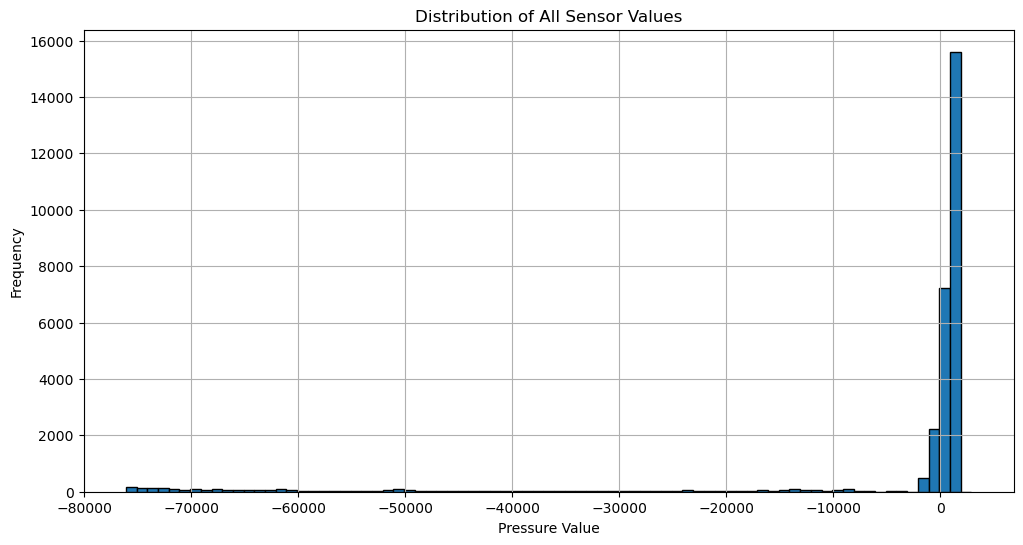

-4461.723435312963
17261.552413893754


In [6]:
imputer = KNNImputer(missing_values = np.nan, n_neighbors = 2).set_output(transform="pandas")

# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1000, 1000), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(np.mean(all_values))
print(np.std(all_values))

We clearly have false measures in our data as there is no trend in those large negative values and a very small frequency. To fix this, we will apply a low filter at -3'000. Once we delete this data don't want to delete the whole column/row as it would remove quite a lot of data. So we prefer to impute the missing data, we could use constant or mean imputation but we'll use KNN imputation to replace them, with 2 neighbors as it will more likely preserve the time continuation.
(maybe try log scaling later instead of removing that much data ?)  
also should we remove outliers from the test data ? It seems not very clever to try predicting false values...

<span style="color:red;"> I think the final data did not replace all the outliers and Nan because we only have 798 sensors in the end

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_888,N_889,N_890,N_892,N_893,N_894,N_895,N_897,N_898,N_900
0,0,281.143955,1462.382827,1656.041967,1322.584393,1473.656845,1480.325846,1650.794639,1511.445756,1397.850463,...,795.767628,-1287.486190,461.350051,202.296319,395.883971,651.026983,-405.358355,-768.389510,336.655683,831.154054
1,2,279.968800,1461.806069,1656.007440,1322.251688,1473.611215,1480.290558,1650.692513,1511.327468,1397.594172,...,795.159479,-1288.550867,461.111159,201.782481,395.553760,649.949956,-405.782281,-769.736168,335.531920,830.963631
2,4,278.797310,1461.224531,1655.972023,1321.919350,1473.565180,1480.255784,1650.589484,1511.207764,1397.338620,...,794.581655,-1289.527645,461.106005,201.470400,395.458253,648.902434,-405.531701,-771.054710,334.539419,830.870655
3,6,277.631157,1460.639147,1655.935750,1321.587287,1473.518663,1480.221507,1650.485576,1511.086587,1397.083769,...,794.048376,-1290.369098,461.426550,201.459983,395.687942,647.909216,-404.343841,-772.329622,333.773806,830.915078
4,9,275.898544,1459.753528,1655.879443,1321.089332,1473.447601,1480.170896,1650.327726,1510.901301,1396.702138,...,793.431491,-1291.210639,462.896536,202.456185,397.004063,646.629125,-400.066605,-774.086664,333.414898,831.441631


(32, 799)


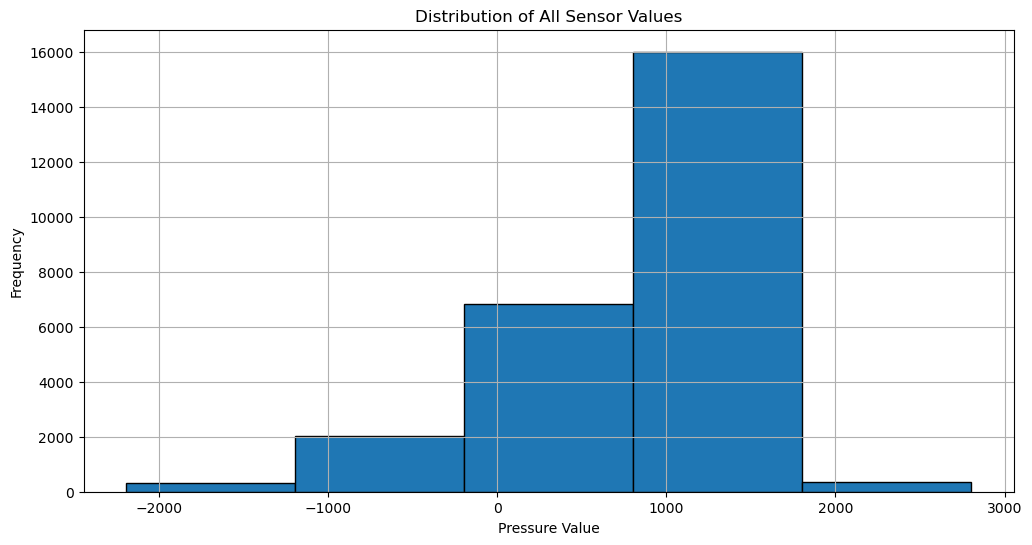

971.0506052044832
780.4852635807711


In [7]:
## clearing values below -3'000:
pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] <= -3000, np.nan)
pressure_test.iloc[:,1:] = pressure_test.iloc[:,1:].mask(pressure_test.iloc[:,1:] <= -3000, np.nan)

## Imputing those now missing values:
pressure_train = imputer.fit_transform(pressure_train)
pressure_test = imputer.fit_transform(pressure_test)

## Set time origin to 0
pressure_test["M.Time[d]"] = (pressure_test["M.Time[d]"] - 1554).astype('int32')
pressure_train["M.Time[d]"] = (pressure_train["M.Time[d]"] - 1554).astype('int32')

## Check the result
display(pressure_train.head(5))
print(pressure_train.shape)

# Visualize distribution with a histogram again(code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1000, 1000), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## New distribution parameters:
print(np.mean(all_values))
print(np.std(all_values))


#### **Humidity**

In [8]:
## approximately computing the mean to see if the humidity is revelant
mean_humidity = humidity_train.mean(axis=0).iloc[1:] ## not keeping the time for the mean (1st column)
mean_humidity.dropna(inplace=True)
print(f"Global mean: {np.mean(mean_humidity, axis=0)}, variance: {np.std(mean_humidity, axis=0)}")

## starting the time at 0 as with pressure:
humidity_test["M.Time[d]"] = (humidity_test["M.Time[d]"] - 1554).astype('int32')
humidity_train["M.Time[d]"] = (humidity_train["M.Time[d]"] - 1554).astype('int32')

## Imputing the missing data
humidity_train = imputer.fit_transform(humidity_train)
humidity_test = imputer.fit_transform(humidity_test)

display(humidity_train.iloc[:,0:13])

Global mean: 98.19472180013585, variance: 5.56673083885869


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12
0,0.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,2.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,4.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,6.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,9.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
5,13.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
6,18.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
7,24.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
8,31.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
9,41.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


The humidity doesn't seem to contain much information and we will discard it for our first model.

#### **Temperature**

In [9]:
display(temperature_train.head(5))

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,17.623059,17.154220,17.641578,17.455701,NaN,16.604935,17.662407,16.503001,16.943823,...,17.503931,17.225297,17.498277,17.268529,17.573474,17.412215,17.526257,17.364940,24.026562,17.538194
1,1556,17.620860,17.154263,17.641672,17.455850,16.415312,16.605042,17.662519,16.503121,16.943985,...,17.510776,17.223290,17.498581,17.267488,17.578925,17.409841,17.522860,17.363663,33.729552,17.537460
2,1558,17.618608,17.154303,17.641766,17.455998,16.415377,16.605148,17.662632,16.503240,16.944146,...,17.534085,17.223733,17.501874,2872.837827,17.599256,17.407913,17.520157,17.363850,41.602481,17.537433
3,1560,17.616334,2717.706176,17.641859,17.456146,16.415440,16.605254,17.662744,16.503357,16.944307,...,17.581610,17.228355,17.509670,17.266326,17.640317,17.406770,17.518750,17.366504,48.218980,17.538652
4,1563,17.612991,17.154388,17.642000,17.456367,16.415531,16.605414,17.662912,16.503530,16.944544,...,17.723547,17.249726,17.535358,17.267759,17.757592,17.408069,17.521699,17.379102,56.258743,17.545154


Here we notice sudden spikes in the temperature going from about 20 to 2'000+ (the mineral would most likely melt at that temperature) and going back down to 20 a few days later. We can consider those value as measurement errors. We can replace those outliers by the mean of the 2 nearest neighbors if they are above a threshold of 500 (we can see it should work well by looking at the graph below), this is called value cliping.

0


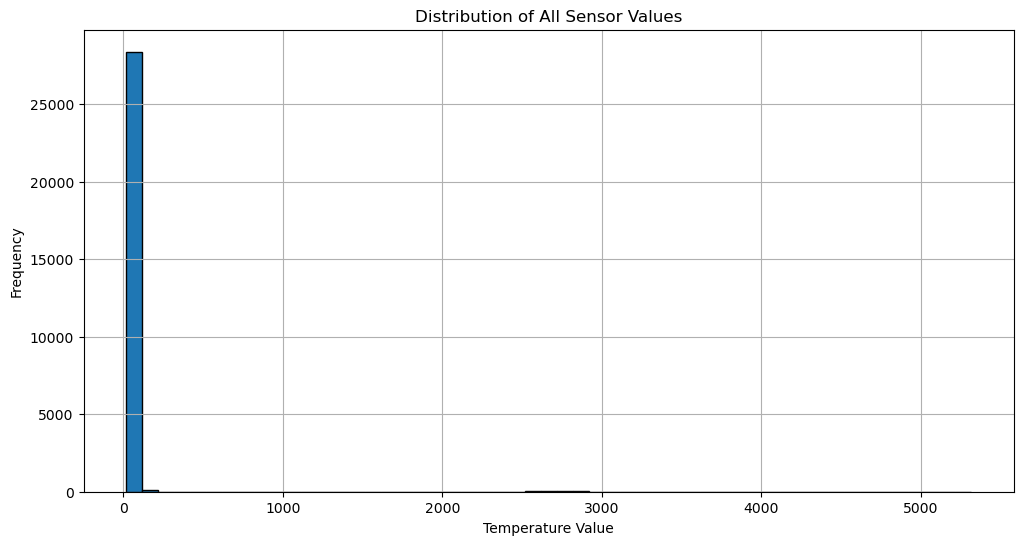

(32, 898)


In [10]:
## We impute the missing data with the 2 nearest neighbors as done with the pressure
temperature_train = imputer.fit_transform(temperature_train) 
print(temperature_train.isnull().sum().sum()) # check that it worked

# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1000, 100), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Applying the filter:
temperature_train.iloc[:,1:] = temperature_train.iloc[:,1:].mask(temperature_train.iloc[:,1:] >= 500, np.nan)

## We impute the missing data with the 2 nearest neighbors as done with the pressure
temperature_train = imputer.fit_transform(temperature_train)
temperature_train.isnull().sum().sum() # check that it worked

## Start the time at 0: 
temperature_train["M.Time[d]"] = (temperature_train["M.Time[d]"] - 1554).astype('int32')
print(temperature_train.shape)

#### **Coordinates**

In [11]:
display(coordinates_train.sample(5))
coordinates_train.info()
coordinates_train["Material"].unique()

,Unnamed: 0,Sensor ID,Index,Material,Coor X [m],Coor Y [m],Coor Z [m],R [m]
480,480,N_481,481,OPA,-15.036608,8.457978,-8.451782,17.249122
587,587,N_588,588,OPA,1.196024,37.189485,-2.263773,2.560301
502,502,N_503,503,OPA,-3.540187,30.940394,0.663370,3.601803
774,774,N_775,775,OPA,2.017119,27.268224,2.283340,3.046704
51,51,N_52,52,OPA,2.288093,29.755106,10.452778,10.700277


<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 0 to 899
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  897 non-null    int64  
 1   Sensor ID   897 non-null    object 
 2   Index       897 non-null    int64  
 3   Material    897 non-null    object 
 4   Coor X [m]  897 non-null    float64
 5   Coor Y [m]  897 non-null    float64
 6   Coor Z [m]  897 non-null    float64
 7   R [m]       897 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 63.1+ KB


array(['OPA', 'SHCR', 'GBM', 'EDZ', 'BBLOCK', 'CAN'], dtype=object)

We can see there are no missing data and apparently no false measures (outliers) on the position and the material, but some columns are useless like the numbering of rows, the Sensor ID, and the index. Because the rows are in an ascending order and as long as the indices match between the files, the name of the sensor and its number doesn't matter. We are also renaming the columns to make it easier later.  

We will also one-hot encode the Material column to feed it later in the model, as they are caterogical features. 

In [12]:
## Not keeping useless columns:
coordinates_train = coordinates_train[["Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
coordinates_test = coordinates_test[["Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]

# changing the column names for faster typing later
new_col_names: dict = {
    "Coor X [m]": "x",
    "Coor Y [m]": "y",
    "Coor Z [m]": "z",
    "R [m]": "r"
}

coordinates_train.rename(columns = new_col_names, inplace=True)
coordinates_test.rename(columns = new_col_names, inplace=True)

## One-hot encoding:
## cf intro to pandas notebook from the weekly exercises
coordinates_test = pd.get_dummies(coordinates_test) 
coordinates_train = pd.get_dummies(coordinates_train)
display(coordinates_train.head(5))
print(coordinates_train.shape)

,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,0.208042,14.436936,-2.875503,2.883019,False,False,False,False,True,False
1,-8.970832,28.229841,-0.134437,8.971839,False,False,False,False,True,False
2,-14.289501,6.685726,-10.399048,17.672862,False,False,False,False,True,False
3,6.114855,2.685645,-3.189981,6.896914,False,False,False,False,True,False
4,4.048845,48.708590,11.260503,11.966289,False,False,False,False,True,False


(897, 10)


### **Feature engineering**

#### **Data normalization**

Data normalization is essential for a faster convergence of the descent methods and an appropriate penalization of the weights. We will use a z-score scaling technique as a min-max scaling would be scalled up by the few outliers left and concentrate the values too much. We'll then make sure the data is not too heavy-tailed for the scaling to work best.

<span style="color:red;"> Why we normalized pressure_test and not coordinates_test?

In [13]:
## Mean and standard deviation are always computed on the training data
## axis = None computes the mean over the entire DataFrame with our current version of pandas: 2.0.3
## but it doesn't work with the std: 
#  https://stackoverflow.com/questions/25140998/pandas-compute-mean-or-std-standard-deviation-over-entire-dataframe

pressure_mean = pressure_train.iloc[:,1:].mean(axis=None) 
pressure_std = pressure_train.iloc[:,1:].values.std()
temperature_mean = temperature_train.iloc[:,1:].mean(axis=None)
temperature_std = temperature_train.iloc[:,1:].values.std()
coordinates_mean = coordinates_train[["x","y","z","r"]].mean(axis=0)
coordinates_std = coordinates_train[["x","y","z","r"]].std(axis=0)

# print(f'Mean pressure: {pressure_mean}')
# print(f'SD of pressure: {pressure_std}')
# print(f'Mean temperature: {temperature_mean}')
# print(f'SD of temperature: {temperature_std}')

pressure_train.iloc[:,1:] -= pressure_mean
pressure_train.iloc[:,1:] /= pressure_std
pressure_test.iloc[:,1:] -= pressure_mean
pressure_test.iloc[:,1:] /= pressure_std
temperature_train.iloc[:,1:] -= temperature_mean
temperature_train.iloc[:,1:] /= temperature_std
coordinates_train[["x","y","z","r"]] -= coordinates_mean
coordinates_train[["x","y","z","r"]] /= coordinates_std

## Check that the values now follow a normal distribution : 
## (the test sets will be off obviously)
assert np.isclose(pressure_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(pressure_train.iloc[:,1:].values.std(), 1)
assert np.isclose(temperature_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(temperature_train.iloc[:,1:].values.std(), 1)
assert np.allclose(coordinates_train[["x","y","z","r"]].mean(axis=0), 0)
assert np.allclose(coordinates_train[["x","y","z","r"]].std(axis=0), 1)



#### **Training and validation split**

We only have 900 known labels, so it is best to implement a K-Fold cross-validation. If we will see that the it is too computational heavy, we can switch to arbitrary training and validation sets system while we are not attached to a power supply

First, we modify the pressure data accordingly to coordinates. The rows are now representing time, while the columns sensors and we want the inverse

In [14]:
pressure_train=pressure_train.T
pressure_test=pressure_test.T

We do the same for temperature

In [ ]:
temperature_train=temperature_train.T

We concatenate coordinates and pressure s.t. X_train=coordinate_train¦pressure_train. Same for X_test. We also create Y_train=temperature_train

<span style="color:red;"> Still not a numpy, there also are Nan values

In [ ]:
X_train=pd.concat([coordinates_train, pressure_train], axis=1)
Y_train=temperature_train

X_test=pd.concat([coordinates_test, pressure_test], axis=1)

display(coordinates_train.head(5))

Model: Recurrent neural net ?? 
(cf lecture 7.3)